# Preliminary CIFAR-10 Analysis

Simple example using CIFAR-10 and a simple fast gradient sign attack.

In [96]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import numpy as np
from scipy.stats import ks_2samp
import pylab as plt
import pandas as pd

from sklearn import svm
from sklearn.metrics import roc_curve, auc


from functools import reduce

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['x', 'y', 'x_fgsm']


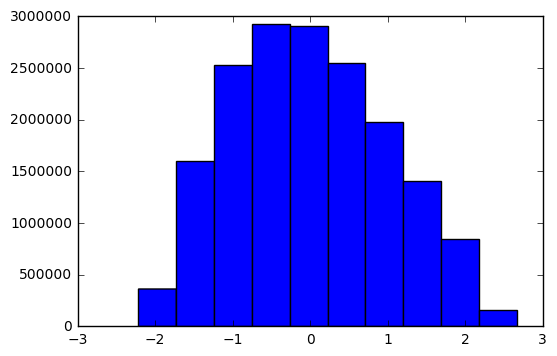

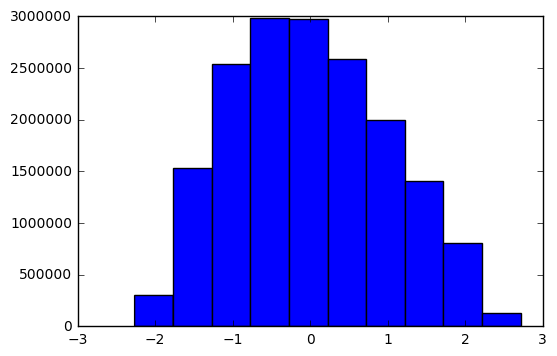

In [86]:
# Look the the raw images, if they are available.
fn = '../cifar10_fgsm_eps0.05.npz'

if os.path.exists(fn):
    f = np.load(fn)
    print(f.keys())
    
    x_orig = f['x']
    x_adv = f['x_fgsm']
    
    plt.figure()
    plt.hist(x_orig.ravel())
    plt.figure()
    plt.hist(x_adv.ravel())


In [43]:
df = pd.read_pickle('../cifar10_stats_df_dec15.pkl')

print(df.dtypes.index)

datasets = pd.unique(df['Dataset'])
examples = pd.unique(df['Example#'])

print('frame has %d datasets and %d unique examples' % (len(datasets), len(examples)))

training = np.random.choice(examples, size=int(np.floor(.6*len(examples))))
testing = [x for x in examples if x not in training]

Index(['Approx_conf', 'Dataset', 'Example#', 'boundary_distance', 'delta_loss',
       'direction_id', 'direction_type', 'ell2_grad', 'k', 'y', 'y_hat'],
      dtype='object')
frame has 2 datasets and 1086 unique examples


1086
1086


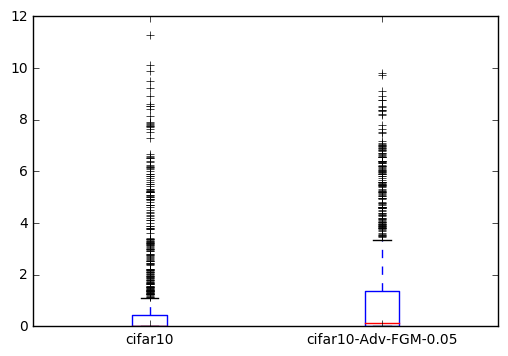

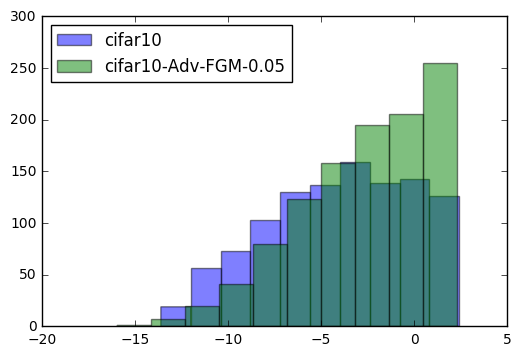

KS Test p-value for hypothesis the two distributions are the same: 8.17471226904e-14


In [99]:
# Here we examine whether the gradient norm seems to be indicative
# of AE vs clean examples.

d_grad = df[df['direction_type'] == 'gradient']

gradient_norms = []
example_id = []
dataset_id= []
for idx, dset in enumerate(datasets):
    rows = d_grad['Dataset'] == dset
    n = np.sum(rows)
    print(n)
    
    gradient_norms.append(d_grad['ell2_grad'][rows])
    example_id.append(d_grad['Example#'][rows])
    dataset_id.append(idx * np.ones((n,)))

    
# visually inspect the distributions
plt.boxplot(gradient_norms, labels=datasets)

plt.figure()
for ii in range(len(gradient_norms)):
    plt.hist(np.log(gradient_norms[ii]), alpha=0.5, label=datasets[ii])
plt.legend(loc='upper left')
plt.show()


# Simple statistical test
_, pv = ks_2samp(*gradient_norms)
print('KS Test p-value for hypothesis the two distributions are the same:', pv)

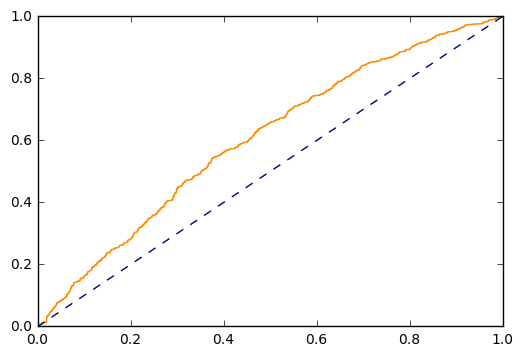

In [95]:
# consider the "classification" performance if we use a single feature, the gradient norm.

g_feat = np.concatenate(gradient_norms, axis=0)
eid = np.concatenate(example_id, axis=0)
y = np.concatenate(dataset_id, axis=0)

fpr, tpr, _ = roc_curve(y, g_feat)
auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.show()